In [1]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls ../share/data/processed/

brand_info_food.csv	       poi_weekly_20211029.csv
cbg_attr_and_cluster_1009.csv  social_distancing_nyc.csv
cbg_attr_and_cluster_1021.csv  weekly_and_core.csv
cbg_distance_matrix.csv        weekly_and_core_with_area.csv
files			       weekly_brand_info.csv
home_weekly_20211029.csv       weekly_patterns_with_general_info.csv
placekey_and_area.csv	       weekly_trips_20211017.csv
poi_info.csv		       weekly_trips_by_cbg.csv


In [2]:
cluster_attr = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
clusters = cluster_attr[['census_block_group', 'Cluster']].set_index('census_block_group')
clusters.head()

,Cluster
census_block_group,
360050001001,2
360050002001,2
360050002002,2
360050002003,3
360050004001,3


In [3]:
poi = pd.read_csv('./exports/poi_health_recategorized.csv')

In [4]:
poiHealth.category.unique()

NameError: name 'poiHealth' is not defined

In [5]:
other_retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    'Specialty Food Stores',
    'Tobacco Stores',
]

other_service = [
    'Drinking Places',
    'Snacks and Bakeries',
]

In [6]:
poi['combined_category'] = poi['category']
poi.loc[poi['category'].isin(other_retail), 'combined_category'] = 'Other Food Retail'
poi.loc[poi['category'].isin(other_service), 'combined_category'] = 'Other Food Service'

In [7]:
poi.columns

Index(['placekey', 'cbg', 'naics_code', 'category', 'sub_category',
       'location_name', 'area_square_feet', 'latitude', 'longitude',
       'combined_category'],
      dtype='object')

In [8]:
categories = poi[['placekey', 'category', 'combined_category', 'cbg']]
categories.head()

,placekey,category,combined_category,cbg
0,222-222@627-s94-nwk,Specialty Food Stores,Other Food Retail,360470395002
1,223-222@627-rw6-zfz,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050386008
2,223-222@627-rwq-vcq,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360050117001
3,223-222@627-sb5-8jv,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360810107011
4,223-222@627-tkd-fvf,Supermarkets and Grocery Stores,Supermarkets and Grocery Stores,360811032021


In [11]:
trips = pd.read_csv('./exports/home_weekly.csv')
trips = trips.merge(categories, on='placekey')
trips = trips.merge(clusters, left_on='home_cbg', right_on='census_block_group')
trips.head(3)

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category,combined_category,cbg,Cluster
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,20.076046,Full-Service Restaurants,Full-Service Restaurants,360471194001,2
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,25.872502,Fast Food Restaurants,Fast Food Restaurants,360470930002,2
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,22.579698,Full-Service Restaurants,Full-Service Restaurants,360470828002,2


In [41]:
trips.describe()

,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cbg,Cluster,year,month
count,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07,2.774869e+07
mean,3.605542e+11,4.256836e+00,1.264457e+01,2.451803e-02,2.451803e-02,8.281217e-01,3.605616e+11,1.791596e+00,2.019378e+03,6.178523e+00
std,2.657840e+08,1.814988e+00,8.308699e+00,2.801561e-02,2.801561e-02,3.719947e+00,2.414030e+08,1.132685e+00,5.636128e-01,3.533570e+00
min,3.600500e+11,4.000000e+00,3.476246e-03,4.999375e-04,4.999375e-04,0.000000e+00,3.600500e+11,0.000000e+00,2.018000e+03,1.000000e+00
25%,3.604703e+11,4.000000e+00,8.360577e+00,1.194030e-02,1.194030e-02,7.536563e-02,3.604703e+11,1.000000e+00,2.019000e+03,3.000000e+00
50%,3.606101e+11,4.000000e+00,1.109257e+01,1.777778e-02,1.777778e-02,2.745234e-01,3.606101e+11,2.000000e+00,2.019000e+03,6.000000e+00
75%,3.608104e+11,4.000000e+00,1.498845e+01,2.797203e-02,2.797203e-02,7.469908e-01,3.608102e+11,3.000000e+00,2.020000e+03,9.000000e+00
max,3.608503e+11,3.016000e+03,3.095143e+03,1.000000e+00,1.000000e+00,3.588715e+03,3.608503e+11,3.000000e+00,2.021000e+03,1.200000e+01


In [12]:
trips.date_range_start = pd.to_datetime(trips.date_range_start, utc=True)
trips['date'] = trips.date_range_start.dt.date
trips['year'] = trips.date_range_start.dt.year
trips['month'] = trips.date_range_start.dt.month

In [13]:
max(trips.date_range_start)

Timestamp('2021-02-15 05:00:00+0000', tz='UTC')

In [14]:
# set the figure and font size
import seaborn as sns 
import matplotlib.ticker as mtick
sns.set(rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":16}) # 'figure.figsize':(20, 8), 

### POI Count per Capita by category

In [15]:
# home POI Count

In [16]:
def get_count_and_pct_df(df, pop, column_label):
    
    Count = df[['placekey', column_label, 'Cluster']].groupby(['Cluster', column_label]).count()
    Count = pd.pivot_table(Count, values='placekey', index=['Cluster'], columns=[column_label])
    for i in Count.columns:
        Count[i] = Count[i] / pop['Total Population'] * 1000 # per 1000 capita
    
    Pct = Count.copy()
    for i in Pct.columns:
        Pct[i] = Pct[i]/Count.sum(axis=1)
    
    return Count, Pct

In [17]:
homepoi = categories.merge(clusters, left_on='cbg', right_on='census_block_group')
clPop = cluster_attr[['Cluster', 'Total Population']].groupby('Cluster').sum()
poiCount, poiPct = get_count_and_pct_df(homepoi, clPop, 'combined_category')

In [18]:
def poi_plots(count_df, pct_df, which_type):
    
    fig, ax = plt.subplots(1,2,figsize=(18,5))

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    count_df.plot.bar(color=colors, ax=ax[0])
    ax[0].set(xlabel='Clusters', ylabel='Number per 1000 Capita', title='%s POI Count per 1000 Capita' % which_type, xticks=count_df.index)
    ax[0].tick_params(axis='x', rotation=0, size=18)
    ax[0].get_legend().remove()

    for i in range(pct_df.shape[1]):
        if i == 0:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
        else:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], bottom=np.sum(pct_df.iloc[:, :i], axis=1), 
                      width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
    ax[1].set(xlabel='Clusters', ylabel='Percentage', title='%s POI Category Composition' % which_type, xticks=pct_df.index)
    ax[1].legend(bbox_to_anchor=(0.45, -0.25, 0.1, 0.1), ncol=4, loc='lower center', 
                  bbox_transform=fig.transFigure, fontsize=15)
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

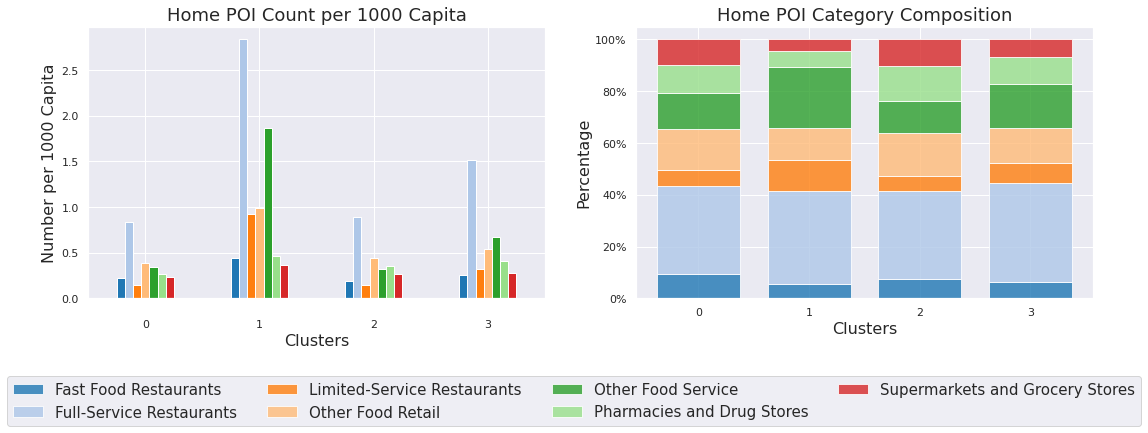

In [19]:
poi_plots(poiCount, poiPct, 'Home')

In [20]:
poiCount.sum(axis=1)

Cluster
0    2.449568
1    7.879381
2    2.618749
3    3.981965
dtype: float64

Text(0.5, 0, '')

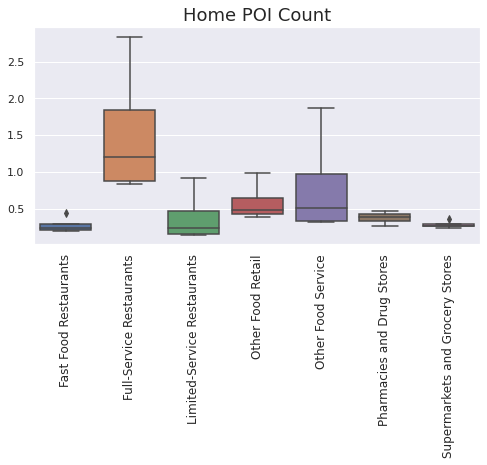

In [21]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=poiCount)
plt.xticks(fontsize=12, rotation=90)
plt.title('Home POI Count')
# plt.ylabel()
plt.xlabel(None)

In [22]:
# Visited POI count by category

In [23]:
vstCount, vstPct = get_count_and_pct_df(trips, 'combined_category')

TypeError: get_count_and_pct_df() missing 1 required positional argument: 'column_label'

In [ ]:
poi_plots(vstCount, vstPct, 'Visited')

In [ ]:
# 2019 V.S. 2020 Visited (Mar - Nov) -- number decreased

In [24]:
trip2019 = trips[(trips.year==2019)&(trips.month>=3)&(trips.month<=11)]
trip2020 = trips[(trips.year==2020)&(trips.month>=3)&(trips.month<=11)]

In [25]:
vstCount19, vstPct19 = get_count_and_pct_df(trip2019, 'combined_category')
vstCount20, vstPct20 = get_count_and_pct_df(trip2020, 'combined_category')

TypeError: get_count_and_pct_df() missing 1 required positional argument: 'column_label'

In [ ]:
changeCount = vstCount20-vstCount19
changePct = (vstCount20-vstCount19)/vstCount19

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

changeCount.T.plot.bar(cmap='tab20c', ax=ax[0])
ax[0].set(xlabel=None, ylabel='Number', title='Changes of Visited POI Count')
ax[0].tick_params(axis='x', labelsize=15)

sns.boxplot(data=changePct, ax=ax[1])
ax[1].set(xlabel=None, ylabel='Percentage', title='Percent Changes of Visited POI Count')
ax[1].tick_params(axis='x', labelsize=15, rotation=90)

### Estimated visitor count by category

In [ ]:
def get_evc_pct_pivot_table(df, value_name, column_label):

    evc = df[['Cluster', column_label, value_name]].groupby(['Cluster', column_label], as_index=False).median()
    evc = pd.pivot_table(evc, values=value_name, index=['Cluster'], columns=[column_label])
    
    evcPct = evc.copy()
    for i in evcPct.columns:
        evcPct[i] = evcPct[i]/evc.sum(axis=1)

    return evc, evcPct

In [ ]:
evc19, evcPct19 = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'combined_category')
evc20, evcPct20 = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'combined_category')

In [ ]:
evcChg = evcPct20 - evcPct19
evcChg.plot.bar(figsize=(10,5), width=0.7)
plt.title('% Changes of Visitation from Home')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [ ]:
# the detailed categories
_, evcPct19_ = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'category')
_, evcPct20_ = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'category')
evcChg_ = evcPct20_ - evcPct19_
evcChg_.plot.bar()

### Time-series /Cluster /Category

In [50]:
tp19 = trip2019[['date', 'estimated_visitor_count', 'combined_category', 'Cluster']]
tp19['date'] = pd.to_datetime(tp19['date'])
tp19['date'] = tp19['date'].dt.strftime('%m-%d')

tp19 = tp19.groupby(['combined_category', 'Cluster', 'date'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19.groupby(['Cluster', 'date'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp19_total = tp19_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp19 = tp19.merge(tp19_total, on=['Cluster', 'date'], how='inner')
tp19['proportion'] = tp19['estimated_visitor_count'] / tp19['estimated_visitor_total']
tp19 = pd.pivot_table(tp19, values='proportion', index=['date'], columns=['combined_category', 'Cluster'])
tp19 = tp19.sort_values(by=['date'])
tp19.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-04                          0.148515  0.109681  0.128163  0.119097   
03-11                          0.146709  0.107498  0.128591  0.118843   
03-18                          0.148658  0.105890  0.129867  0.116945   
03-25                          0.148569  0.105784  0.127487  0.119772   
04-01                          0.148443  0.107742  0.132777  0.118079   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-04                             0.351273  0.366270  0.374768  0.389170   
03-11                             0.353915  0.364475  0.373541  0.388577   
03-18                             0.353059  0.366784  0.374705  0.387976   
03-25                             0.355252  0.366457  0.378195  0.384743   
04-01                             0.351677  0.364839  0.373575  0.388655   

combined_category Limited-Service Restaurants            ...  \
Cluster                                     0         1  ...   
date                                                     ...   
03-04                                0.092690  0.125102  ...   
03-11                                0.089786  0.127739  ...   
03-18                                0.087935  0.126044  ...   
03-25                                0.088232  0.125862  ...   
04-01                                0.091421  0.126594  ...   

combined_category Other Food Service           Pharmacies and Drug Stores  \
Cluster                            2         3                          0   
date                                                                        
03-04                       0.134312  0.154555                   0.064615   
03-11                       0.136454  0.155727                   0.063405   
03-18                       0.137151  0.157187                   0.063996   
03-25                       0.138319  0.158750                   0.063732   
04-01                       0.136607  0.155102                   0.064642   

combined_category                                \
Cluster                   1         2         3   
date                                              
03-04              0.038458  0.071433  0.056930   
03-11              0.037969  0.070322  0.058448   
03-18              0.039897  0.068726  0.058258   
03-25              0.037748  0.072529  0.059084   
04-01              0.038821  0.069067  0.057169   

combined_category Supermarkets and Grocery Stores                      \
Cluster                                         0         1         2   
date                                                                    
03-04                                    0.067986  0.038492  0.069737   
03-11                                    0.066130  0.039624  0.068644   
03-18                                    0.068770  0.039495  0.070339   
03-25                                    0.064870  0.036645  0.064744   
04-01                                    0.066333  0.038050  0.068678   

combined_category            
Cluster                   3  
date                         
03-04              0.059630  
03-11              0.060090  
03-18              0.059063  
03-25              0.059091  
04-01              0.059964  

[5 rows x 28 columns]

In [49]:
tp20 = trip2020[['date', 'estimated_visitor_count', 'combined_category', 'Cluster']]
tp20['date'] = pd.to_datetime(tp20['date'])
tp20['date'] = tp20['date'].dt.strftime('%m-%d')

tp20 = tp20.groupby(['combined_category', 'Cluster', 'date'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20.groupby(['Cluster', 'date'], as_index=False).agg({'estimated_visitor_count': 'sum'})
tp20_total = tp20_total.rename(columns={'estimated_visitor_count': 'estimated_visitor_total'})
tp20 = tp20.merge(tp20_total, on=['Cluster', 'date'], how='inner')
tp20['proportion'] = tp20['estimated_visitor_count'] / tp20['estimated_visitor_total']
tp20 = pd.pivot_table(tp20, values='proportion', index=['date'], columns=['combined_category', 'Cluster'])
tp20 = tp20.sort_values(by=['date'])
tp20.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-02                          0.152514  0.108772  0.136758  0.121253   
03-09                          0.150165  0.110616  0.134597  0.118226   
03-16                          0.139081  0.104610  0.122300  0.109497   
03-23                          0.146781  0.105011  0.123991  0.113121   
03-30                          0.156684  0.107596  0.130143  0.119385   
04-06                          0.159607  0.111309  0.129959  0.124632   
04-13                          0.162216  0.113608  0.131298  0.126341   
04-20                          0.160841  0.110824  0.128921  0.127450   
04-27                          0.163393  0.116153  0.132993  0.128057   
05-04                          0.155402  0.106160  0.124932  0.120409   
05-11                          0.154263  0.110450  0.127850  0.125072   
05-18                          0.152496  0.114363  0.126219  0.125121   
05-25                          0.152452  0.111716  0.130661  0.125565   
06-01                          0.152691  0.110293  0.126313  0.124837   
06-08                          0.155742  0.109262  0.129066  0.123469   
06-15                          0.151926  0.111181  0.131173  0.121823   
06-22                          0.153465  0.109229  0.130551  0.125259   
06-29                          0.150935  0.105283  0.131080  0.119776   
07-06                          0.154907  0.111723  0.131672  0.124093   
07-13                          0.150705  0.108467  0.130562  0.121057   
07-20                          0.151877  0.103438  0.130273  0.119554   
07-27                          0.151864  0.103115  0.129202  0.119439   
08-03                          0.150373  0.104440  0.128930  0.120639   
08-10                          0.154726  0.107236  0.129573  0.119383   
08-17                          0.152442  0.109321  0.132533  0.119532   
08-24                          0.151819  0.105498  0.130892  0.118458   
08-31                          0.151749  0.102057  0.127796  0.120558   
09-07                          0.148580  0.103007  0.127964  0.120574   
09-14                          0.151917  0.109313  0.132372  0.120405   
09-21                          0.146204  0.103961  0.129499  0.116844   
09-28                          0.150424  0.100095  0.124871  0.119088   
10-05                          0.150368  0.102592  0.126861  0.119196   
10-12                          0.145086  0.103990  0.126011  0.118749   
10-19                          0.145756  0.105131  0.130692  0.116622   
10-26                          0.147839  0.103276  0.126920  0.116589   
11-02                          0.148960  0.102325  0.128628  0.120261   
11-09                          0.145054  0.103252  0.123637  0.116817   
11-16                          0.147480  0.106131  0.128403  0.118918   
11-23                          0.138821  0.102087  0.122548  0.116674   
11-30                          0.150256  0.102340  0.130538  0.116958   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-02                             0.345175  0.359552  0.363760  0.378727   
03-09                             0.332577  0.349283  0.353501  0.366287   
03-16                             0.314037  0.328041  0.341977  0.347269   
03-23                             0.321222  0.336845  0.346852  0.339785   
03-30                             0.309301  0.320285  0.333689  0.324305   
04-06                             0.312470  0.324333  0.336744  0.331411   
04-13                             0.311961  0.325452  0.340967  0.333554   
04-20                             0.317542  0.334492  0.339474  0.335502   
04-27                   

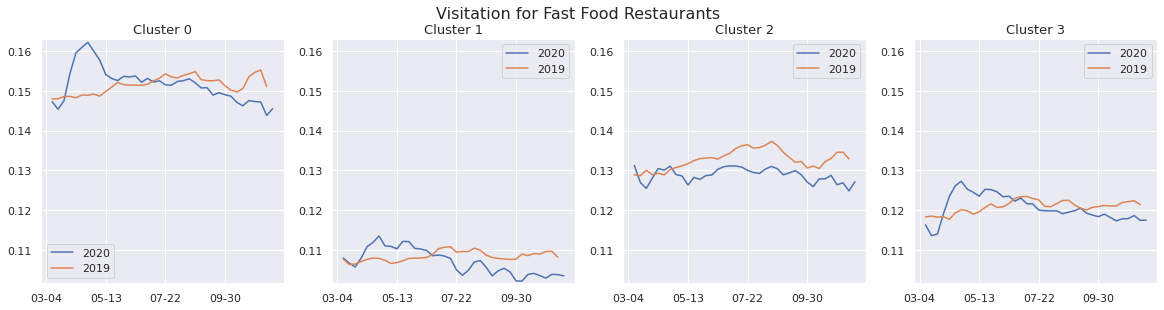

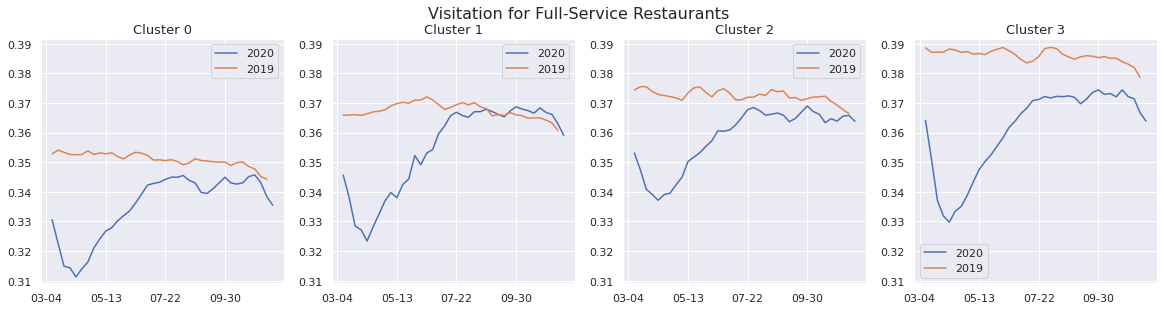

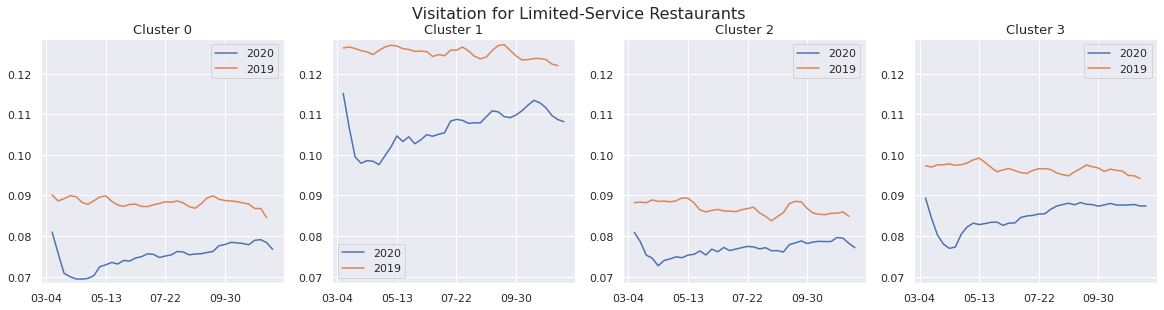

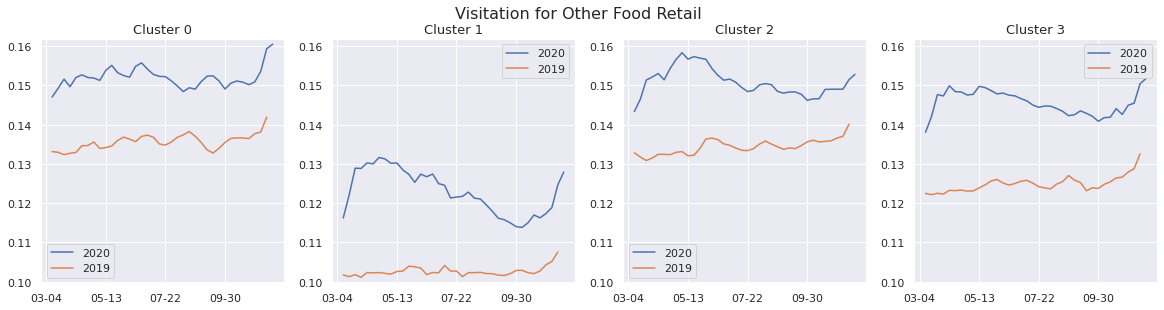

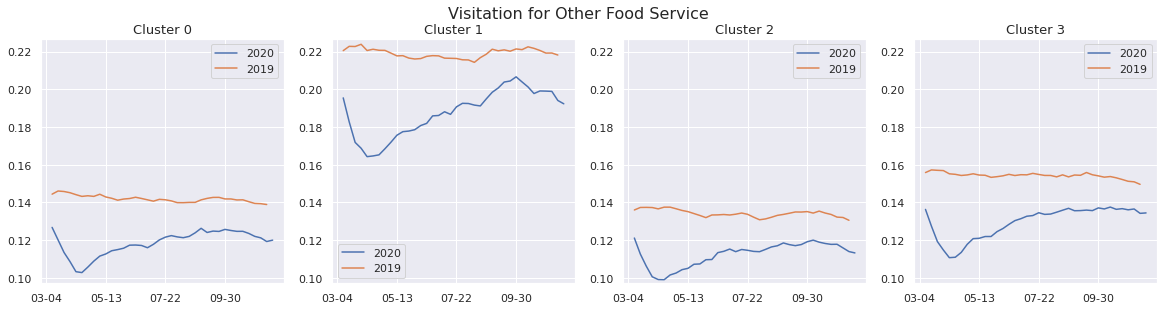

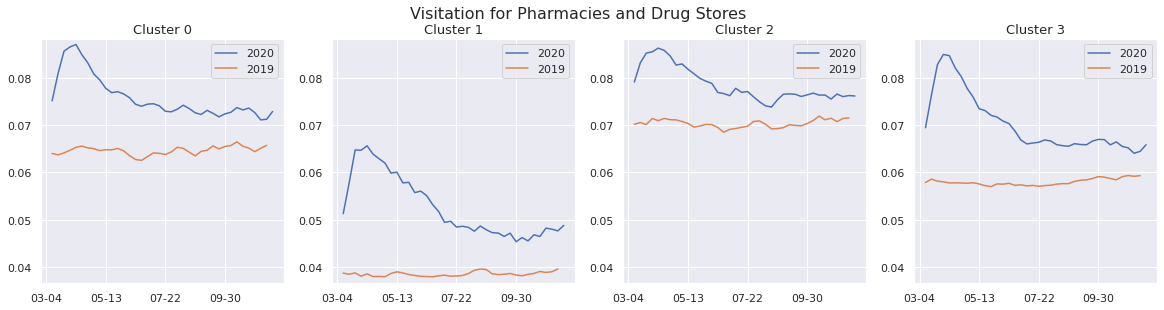

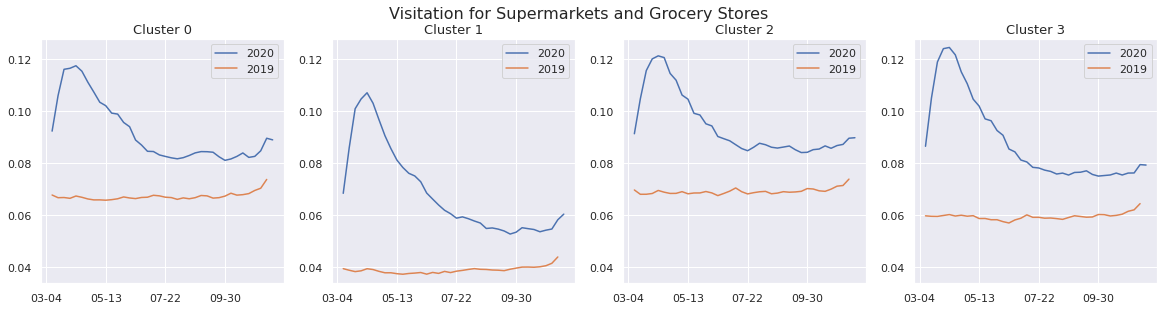

In [70]:
for i, category in enumerate(tp20.columns.levels[0]):
    fig, axes = plt.subplots(1,4,figsize=(20,4.5))
    fig.suptitle('Visitation for %s ' % category, fontsize=16, verticalalignment='top')
    ax = axes.ravel()
    
    min_y = 1
    max_y = 0
    
    for cl in range(4):
        tp20[(category, cl)].rolling(3, center=True).mean().plot(ax=ax[cl], label='2020', legend=True)
        tp19[(category, cl)].rolling(3, center=True).mean().plot(ax=ax[cl], label='2019', legend=True)
        ax[cl].set(xlabel=None)
        ax[cl].set_title('Cluster %d' % cl, fontdict={'fontsize': 13})
        min_y = min(min_y, ax[cl].get_ylim()[0])
        max_y = max(max_y, ax[cl].get_ylim()[1])
        
    for cl in range(4):
        ax[cl].set_ylim([min_y, max_y])
        
    plt.show()

In [29]:
# get category % of each cluser each day
tp20pct = tp20.copy()
for c in range(4):
    total_each_week = tp20pct[list(tp20pct.columns[c+4*i] for i in range(7))].sum(axis=1)
    for k in range(7):
        tp20pct[tp20pct.columns[c+4*k]] = tp20pct[tp20pct.columns[c+4*k]] / total_each_week
tp20pct.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-02                          0.142167  0.138845  0.140694  0.142051   
03-09                          0.140837  0.137857  0.141208  0.141654   
03-16                          0.141640  0.137157  0.139188  0.140117   
03-23                          0.141496  0.132007  0.138097  0.139996   
03-30                          0.141314  0.133968  0.140722  0.141138   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-02                             0.142236  0.141050  0.143875  0.143256   
03-09                             0.140590  0.142762  0.143826  0.143465   
03-16                             0.140774  0.142835  0.143283  0.144431   
03-23                             0.143906  0.146080  0.144596  0.144199   
03-30                             0.142513  0.143313  0.144440  0.143765   

combined_category Limited-Service Restaurants            ...  \
Cluster                                     0         1  ...   
date                                                     ...   
03-02                                0.140142  0.146293  ...   
03-09                                0.141014  0.144763  ...   
03-16                                0.139856  0.143987  ...   
03-23                                0.141587  0.146906  ...   
03-30                                0.141070  0.147392  ...   

combined_category Other Food Service           Pharmacies and Drug Stores  \
Cluster                            2         3                          0   
date                                                                        
03-02                       0.144479  0.144191                   0.142385   
03-09                       0.143521  0.142090                   0.143013   
03-16                       0.143930  0.143026                   0.143425   
03-23                       0.144580  0.143518                   0.142246   
03-30                       0.142840  0.142740                   0.140624   

combined_category                                \
Cluster                   1         2         3   
date                                              
03-02              0.138692  0.142017  0.142119   
03-09              0.138111  0.141038  0.143862   
03-16              0.136865  0.142058  0.142139   
03-23              0.130090  0.141161  0.141563   
03-30              0.132770  0.140630  0.143419   

combined_category Supermarkets and Grocery Stores                      \
Cluster                                         0         1         2   
date                                                                    
03-02                                    0.145355  0.140917  0.144479   
03-09                                    0.146279  0.147920  0.146824   
03-16                                    0.146393  0.150627  0.147537   
03-23                                    0.143786  0.146791  0.144771   
03-30                                    0.144998  0.147345  0.145752   

combined_category            
Cluster                   3  
date                         
03-02              0.145843  
03-09              0.146446  
03-16              0.147649  
03-23              0.146324  
03-30              0.144995  

[5 rows x 28 columns]

In [187]:
# get category % of each cluser each day
tp19pct = tp19.copy()
for c in range(4):
    total_each_week = tp19pct[list(tp19pct.columns[c+4*i] for i in range(7))].sum(axis=1)
    for k in range(7):
        tp19pct[tp19pct.columns[c+4*k]] = tp19pct[tp19pct.columns[c+4*k]] / total_each_week
tp19pct.head()

combined_category Fast Food Restaurants                                \
Cluster                               0         1         2         3   
date                                                                    
03-04                          0.143130  0.140745  0.141217  0.140652   
03-11                          0.142643  0.139493  0.141712  0.140973   
03-18                          0.143647  0.139981  0.141705  0.140953   
03-25                          0.142950  0.139962  0.141076  0.140882   
04-01                          0.142873  0.139234  0.141915  0.141414   

combined_category Full-Service Restaurants                                \
Cluster                                  0         1         2         3   
date                                                                       
03-04                             0.142884  0.142337  0.143865  0.143268   
03-11                             0.142270  0.142034  0.144392  0.143126   
03-18                             0.142743  0.142594  0.143770  0.142653   
03-25                             0.142950  0.143556  0.144305  0.142116   
04-01                             0.143044  0.142506  0.144089  0.142755   

combined_category Limited-Service Restaurants            ...  \
Cluster                                     0         1  ...   
date                                                     ...   
03-04                                0.142612  0.142739  ...   
03-11                                0.143841  0.145915  ...   
03-18                                0.142860  0.143598  ...   
03-25                                0.142950  0.144892  ...   
04-01                                0.143060  0.144514  ...   

combined_category Other Food Service           Pharmacies and Drug Stores  \
Cluster                            2         3                          0   
date                                                                        
03-04                       0.145721  0.143853                   0.142459   
03-11                       0.144682  0.142509                   0.141356   
03-18                       0.143708  0.143507                   0.142093   
03-25                       0.145142  0.143437                   0.142957   
04-01                       0.144444  0.143202                   0.142283   

combined_category                                \
Cluster                   1         2         3   
date                                              
03-04              0.140326  0.140744  0.143527   
03-11              0.140932  0.141243  0.143678   
03-18              0.141216  0.141844  0.143830   
03-25              0.139275  0.141183  0.143367   
04-01              0.141876  0.142324  0.143829   

combined_category Supermarkets and Grocery Stores                      \
Cluster                                         0         1         2   
date                                                                    
03-04                                    0.143438  0.145006  0.143865   
03-11                                    0.143364  0.144639  0.144613   
03-18                                    0.143334  0.144055  0.144212   
03-25                                    0.142102  0.142645  0.142123   
04-01                                    0.143379  0.145144  0.143462   

combined_category            
Cluster                   3  
date                         
03-04              0.144555  
03-11              0.145261  
03-18              0.145142  
03-25              0.146334  
04-01              0.145749  

[5 rows x 28 columns]

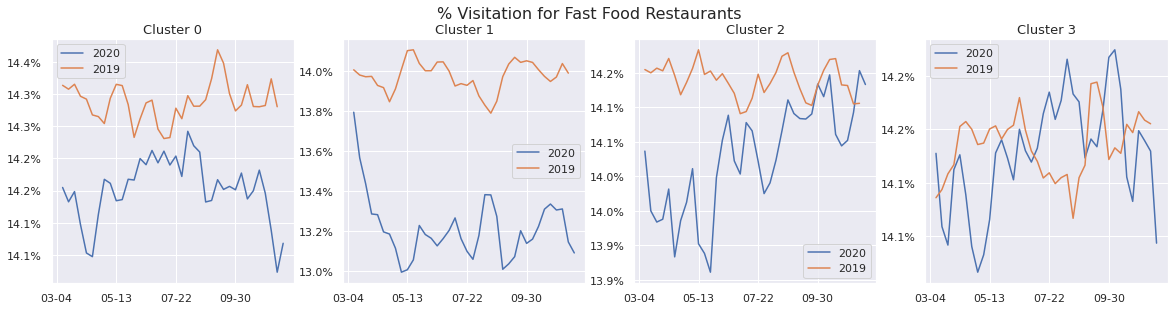

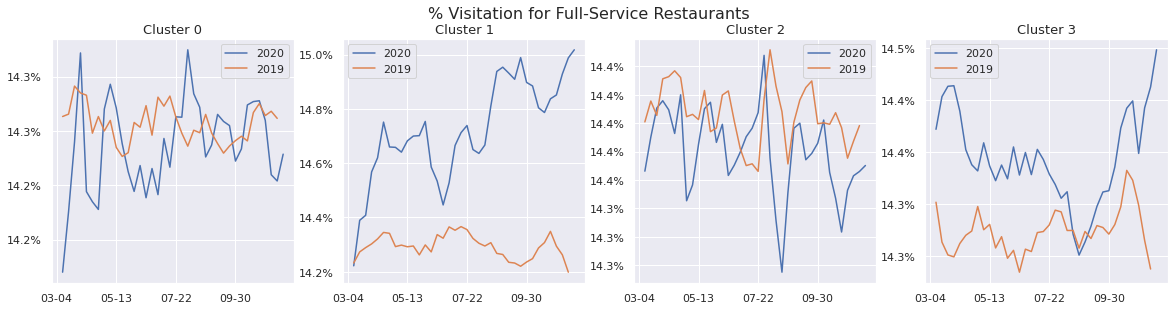

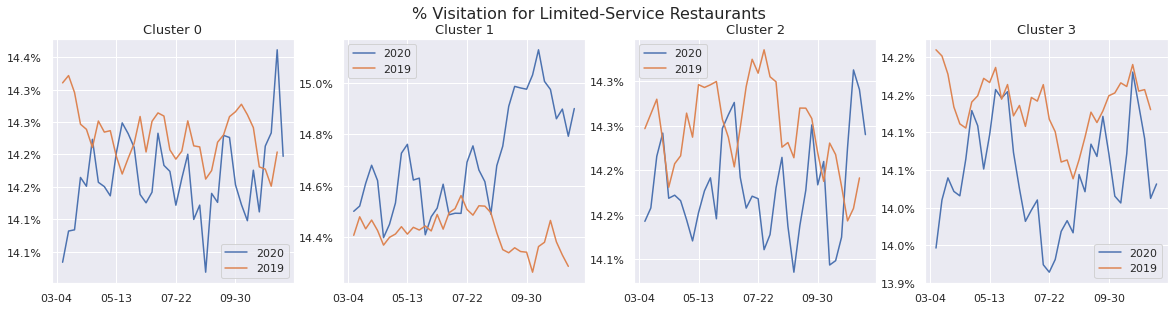

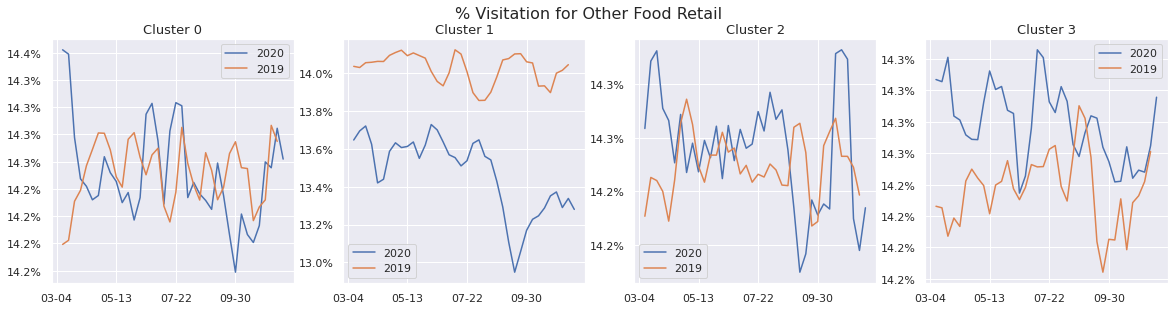

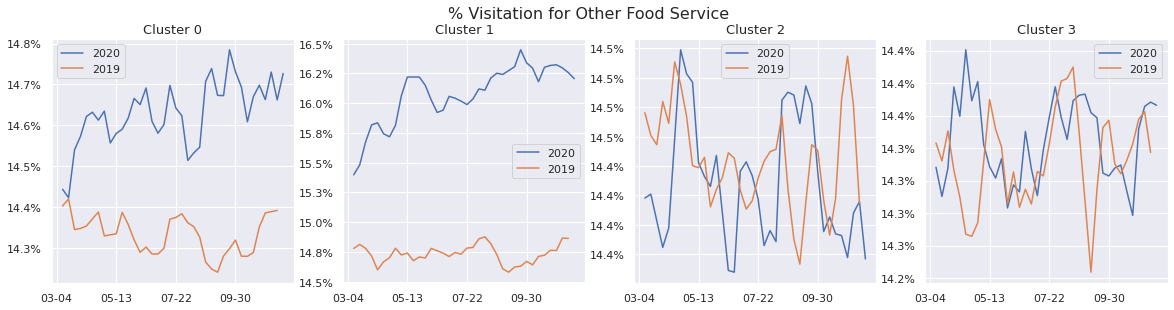

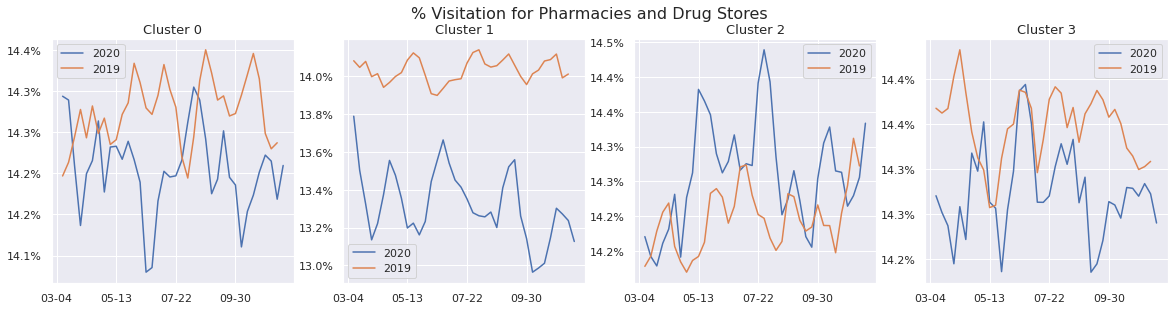

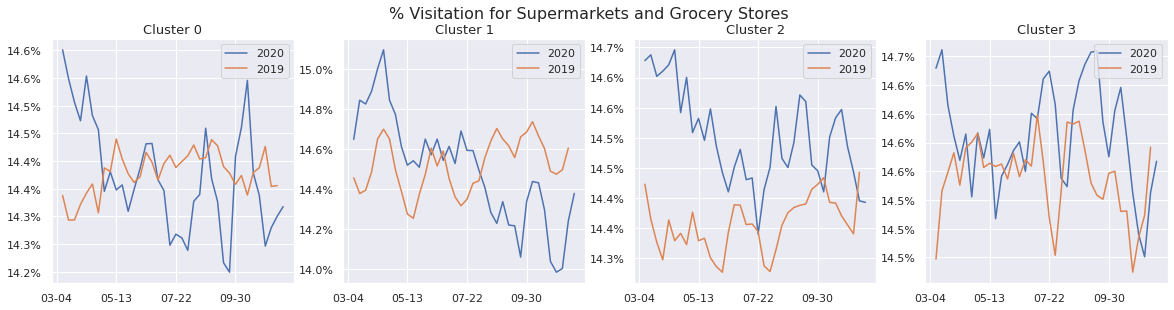

In [225]:
# COLORS = ['#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
for n, i in enumerate(tp20pct.columns):
    if (n-1)//4 != n//4:
        fig, axes = plt.subplots(1,4,figsize=(20,4.5))
        fig.suptitle('%% Visitation for %s ' % i[0], fontsize=16, verticalalignment='top')
        ax = axes.ravel()
    cl = n%4
    tp20pct[i].rolling(3, center=True).mean().plot(ax=ax[cl], label='2020', legend=True)
    tp19pct[i].rolling(3, center=True).mean().plot(ax=ax[cl], label='2019', legend=True)
    ax[cl].set(xlabel=None)
    ax[cl].set_title('Cluster %d' % cl, fontdict={'fontsize': 13})
    ax[cl].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))

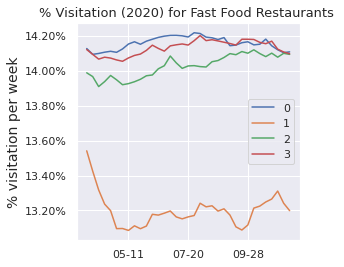

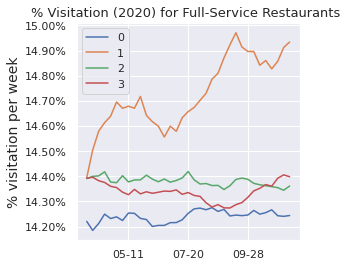

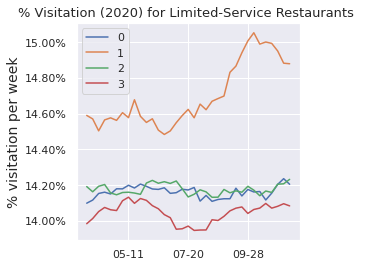

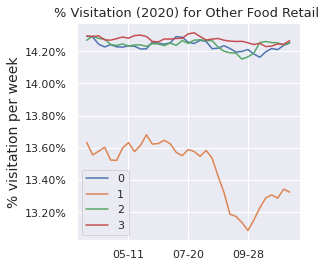

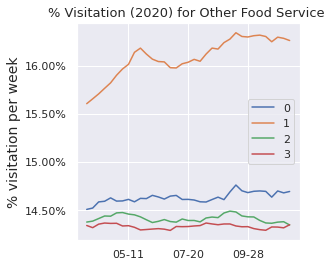

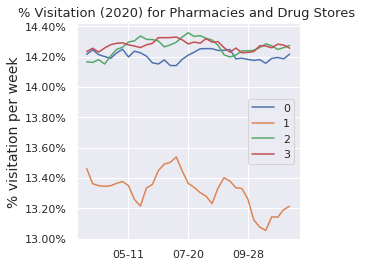

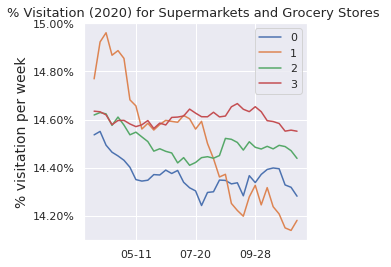

In [201]:
for n, i in enumerate(tp20pct.columns):
    if (n-1)//4 != n//4:
        fig, ax = plt.subplots(figsize=(4,4))
#         fig.suptitle('Visitation for %s ' % i[0], fontsize=14, verticalalignment='top')
    cl = n%4
    tp20pct[i].rolling(6, center=True).mean().plot(ax=ax, label=cl, legend=True) #, color=COLORS[cl]
    ax.set(xlabel=None, ylabel='% visitation per week')
    ax.set_title("%% Visitation (2020) for %s " % i[0], fontdict={'fontsize': 13})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))